classifier_analysis.ipynb is a notebook that analyzes the predictions of a trained signal vs background classifier DNN.

Here it is used to analyze the output of the Josh's most recent classifier DNN. 
This DNN was trained/validated on ~50k events. Here we are testing it on another ~50k events. Events are x = 20x20x60 3d SiPM maps, y = 0 or 1 labels

The notebook provides histograms of DNN output and plots of the figure of merit. It also allows the user to impose an artificial threshold for acceptance (not the default 0.5) and then study the accepted background. Here, we are studying the accepted background events by going back to the montecarlo truth and looking at the events there.

The most interesting discovery we've made with this study is that the DNN tends to accept background events that have multiple high energy tracks in the montecarlo. What seems to be happening (if i understand Josh correctly) is that in these accepted background events, the single electron near the beginning of it's track collides with another electron and produces a delta ray. This delta ray takes a substantial amount of the total energy (2.5 MeV) of the event, and the event ends up looking like two electrons moving outward from a vertex ending in two blobs.

This hypothesis might help to explain why we've seen such dramatic decrease (98% -> 80%) in accuracy in this diffusion run. The more diffusion we have, the harder it should be for the DNN to tell the difference between two electrons that diverge from a vertex and one electron that creates a delta ray a few miliseconds along its track.

In [1]:
%matplotlib inline
from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy  as np
import tables as tb
import random as rd
import keras.backend.tensorflow_backend as K

from __future__  import print_function
from scipy.stats import threshold

from keras.models               import Model, load_model

import tensorflow as tf
tf.python.control_flow_ops = tf

Using TensorFlow backend.


Josh's code to create the test dataset

In [2]:
# Dimensions and numbers of events
Ntrain = 40000     # number of training events per sample
Ntot = 44000
xdim = 20
ydim = 20
zdim = 60

## TEST EVENTS
f_start = 0
f_end = 25
# Read in the signal events.
print("Reading test signal events...")
for fn in range(f_start,f_end):
    #print("-- Reading file {0}".format(fn))
    s_dat = tb.open_file("/home/jrenner/data/classification/bb_1M_v0_08_07_with_evtnum/hdf5_maps_NEW_training_MC_si_{0}.h5".format(fn), 'r')
    if(fn == f_start):
        stest_evt = np.array(s_dat.root.evtnum)
        stest_array = np.array(s_dat.root.maps)
        stest_energies = np.array(s_dat.root.energies)
    else:
        stest_evt = np.concatenate([stest_evt, np.array(s_dat.root.evtnum)])
        stest_array = np.concatenate([stest_array,np.array(s_dat.root.maps)])
        stest_energies = np.concatenate([stest_energies,np.array(s_dat.root.energies)])
        
# Read in the background events.
print("Reading background events...")
for fn in range(f_start,f_end):
    #print("-- Reading file {0}".format(fn))
    b_dat = tb.open_file("/home/jrenner/data/classification/se_1M_v0_08_07_with_evtnum/hdf5_maps_NEW_training_MC_bg_{0}.h5".format(fn), 'r')
    if(fn == f_start):
        btest_evt = np.array(b_dat.root.evtnum)
        btest_array = np.array(b_dat.root.maps)
        btest_energies = np.array(b_dat.root.energies)
    else:
        btest_evt = np.concatenate([btest_evt, np.array(b_dat.root.evtnum)])
        btest_array = np.concatenate([btest_array,np.array(b_dat.root.maps)])
        btest_energies = np.concatenate([btest_energies,np.array(b_dat.root.energies)])

print("Read {0} test signal events and {1} test background events.".format(len(stest_array),len(btest_array)))

# Concatenate the datasets
print("Concatenating datasets...")
x_e = np.concatenate([stest_array, btest_array])
y_e = np.concatenate([np.ones([len(stest_array),1]), np.zeros([len(btest_array),1])])
x_e = np.reshape(x_e, (len(x_e), xdim, ydim, zdim, 1))
num_signal = stest_evt.shape[0]
num_background = btest_evt.shape[0]
print("Done.")

Reading test signal events...
Reading background events...
Read 47412 test signal events and 44657 test background events.
Concatenating datasets...
Done.


Signal events are the first 47412 events, background events follow. Now we find the accepted background events. 

Load Model

In [3]:
DNN = load_model('/home/jrenner/IC/DNN/Notebooks/classification/models/conv3d_classifier_20_060116.h5')

Get DNN predictions

In [4]:
bg_pred = DNN.predict(x_e[num_signal:])
si_pred = DNN.predict(x_e[:num_signal])
print('With .5 threshold: ')
print('Background: '+ str(DNN.evaluate(x_e[num_signal:], y_e[num_signal:])))
print('Signal: '+ str(DNN.evaluate(x_e[:num_signal], y_e[:num_signal])))

With .5 threshold: 
44657/44657 [==============================] - 10s    
Background: [0.4518928913212758, 0.79322390666636811]
47392/47412 [============================>.] - ETA: 0sSignal: [0.447559324953613, 0.81721926938830713]


In [5]:
def compute_efficiency(th, predictions, labels):
    total_signal_events = float(len(labels))
    correct  = float((predictions >= th).sum())
    return correct/total_signal_events

def compute_background_rejection(th, predictions, labels):
    total_background_events = float(len(labels))
    correct = float((predictions < th).sum())
    return correct/total_background_events

In [6]:
# Plot a sample of accepted background events in this file
def plot_tracks(bg, f_accbg, bg_pred, btest_evt):
    """
    bg is the pytable
    
    f_accbg are the accepted backgrounds in this file
    
    bg_pred are the DNN predictions for background events
    
    btest_evt are the event numbers of the the background events in the order
    the events appear in bg_pred.
    """
    fig = plt.figure()
    fig.set_figheight(35.0)
    fig.set_figwidth(40.0)
    num_plots = min(9, len(f_accbg))
    sample = rd.sample(f_accbg, num_plots)

    plt_int = 331
    for ev in sample:

        track = [[],[],[],[]]
        for row in bg.iterrows():

            if row['event_indx'] == ev:
                track[0].append(row['hit_position'][0])
                track[1].append(row['hit_position'][1])
                track[2].append(row['hit_position'][2])
                track[3].append(row['hit_energy'])

            if row['event_indx'] > ev:
                break

        track = np.array(track) 

        # Plot the track
        ax = fig.add_subplot(plt_int, projection='3d')
        emax = np.max(track[3])
        s1=ax.scatter(track[0],track[1],track[2],c=track[3],cmap=plt.get_cmap('rainbow'),vmin=0,vmax=emax,s=50,edgecolors='None')
        s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
        ax.set_title('Event: ' + str(ev) +  '. Accepted background prediction: ' + str(bg_pred[np.where(btest_evt == ev)[0]]))
        cb1 = plt.colorbar(s1)
        plt.grid(True)

        plt_int += 1

    plt.show()



In [7]:
def count_gammas(bg, f_accbg):
    current_ev = -1
    total_ev = 0
    total_gammas = 0 
    acc_gammas = 0 
    found_gamma = False

    for row in bg.iterrows():
        if row['event_indx'] != current_ev:
            total_ev += 1
            current_ev = row['event_indx']
            found_gamma = False
        if not found_gamma and row['particle_name'] == 'gamma':
            total_gammas += 1
            found_gamma = True
            if (f_accbg == current_ev).any():
                acc_gammas +=1
                
    return acc_gammas, total_gammas, total_ev
#count_gammas(bg)

In [8]:
# Look to see if presence of multiple high energy tracks in a single 
# background event correlates with background acceptance
def count_mht(bg, f_accbg, high_energy, total_ev):
    current_ev = -1 
    current_track = -1
    total_mht = 0
    acc_mht = 0
    rej_mht = 0
    num_ht = 0  ## track number of high energy tracks in current event
    skip_event = False
    skip_track = False 

    for row in bg.iterrows():

        # check for new event, if new reset flags
        if row['event_indx'] != current_ev:
            current_ev = row['event_indx']
            current_track = 0
            num_ht = 0
            skip_event = False
            skip_track = False

        elif skip_event:
            continue

        # check for new track
        if row['mctrk_indx'] != current_track:
            current_track = row['mctrk_indx']
            skip_track = False

        elif skip_track:
            continue

        # check track energy
        if row['energy'] > high_energy:
            num_ht += 1
            current_track = row['mctrk_indx']
            skip_track = True
            continue

        # check to see if event has multiple high energy tracks
        if num_ht > 1:

            total_mht += 1
            if (f_accbg == current_ev).any():
                acc_mht += 1
            else:
                rej_mht += 1
            skip_event = True
    
    nacc_mht = float(acc_mht)
    nrej_mht = float(rej_mht)
    nevt_mht = float(total_mht)
    
    return nevt_mht, nacc_mht, nrej_mht
    #print('---High Energy Threshold set to ' + str(float(high_energy)) + ' Mev')
    #print(str(round(float(acc_mht)/len(f_accbg)*100)) + '% of accepted bg events have multiple high energy tracks')
    #print(str(round(float(rej_mht)/(total_ev - len(f_accbg))*100)) + '% of rejected bg events have multiple high energy tracks')
    #print(str(round(float(total_mht)/total_ev*100)) + '% of total bg events have multiple high energy tracks')  
    
#count_mht(bg, f_accbg)

Find the average energy of the two highest energy tracks in each event

In [9]:
def get_max_track_energies(bg, f_accbg, total_ev):   
    bg_e = np.zeros((total_ev, 2), dtype=np.float32)
    #accbg_e = np.zeros((len(f_accbg), 2), dtype=np.float32)
    #rejbg_e = np.zeros((total_ev - len(f_accbg), 2) dtype=np.float32)

    accbg_e = []
    rejbg_e = []

    current_ev = -1
    evi = -1       # index of events in bg_e
    acci = -1     # in accbg_e
    reji = -1     # in rejbg_e
    max_et = -1    # record max energy track so that it isn't made 2nd energy track also

    for row in bg.iterrows():

        # if new event reset flags
        if row['event_indx'] != current_ev:
            current_ev = row['event_indx']
            evi += 1 
            max_et = -1  
            new_ev = True

        # if track found with highest energy so far found for event
        if row['energy'] > bg_e[evi, 0]:
            bg_e[evi, 1] = bg_e[evi, 0]
            bg_e[evi, 0] = row['energy']
            max_et = row['mctrk_indx']

            if (f_accbg == current_ev).any():
                if new_ev: 
                    accbg_e.append(bg_e[evi])

                else:
                    accbg_e[-1] = bg_e[evi]

            else:
                if new_ev:
                    rejbg_e.append(bg_e[evi])

                else:
                    rejbg_e[-1] = bg_e[evi]    

            new_ev = False

        # if track found with second highest energy for event  
        elif row['energy'] > bg_e[evi, 1] and row['mctrk_indx'] != max_et:
            bg_e[evi, 1] = row['energy']

            if (f_accbg == current_ev).any():
                accbg_e[-1] = bg_e[evi]

            else:
                rejbg_e[-1] = bg_e[evi]
    return bg_e, np.array(accbg_e), np.array(rejbg_e)

#bg_e, accbg_e, rejbg_e = get_max_track_energies(bg, f_accbg)

Look at FOM

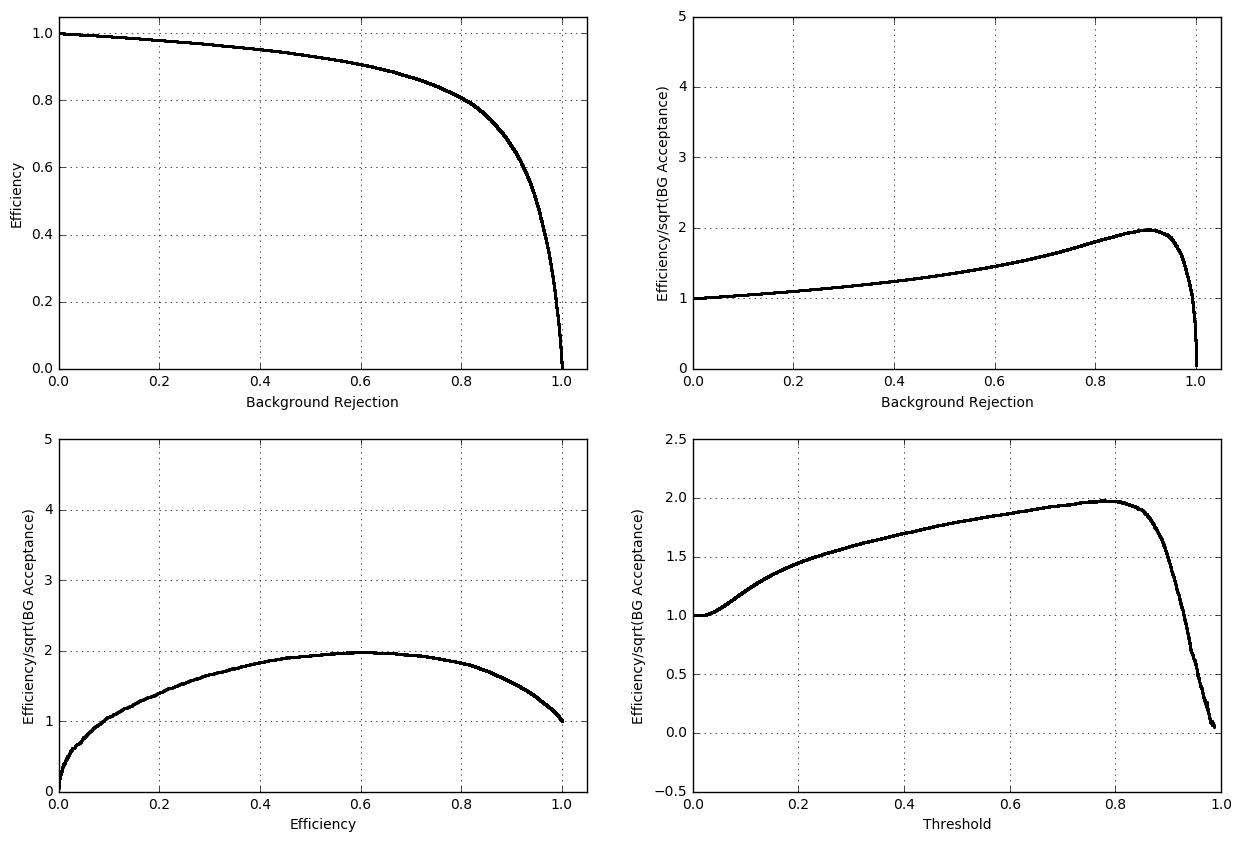

In [10]:
length = 10000
efficiency = np.zeros((length,),dtype=np.float32)
background_rejection = np.zeros((length,),dtype=np.float32)

fom       = 0
fom_thres =-1
THR = np.array(range(length), dtype=np.float32)/float(length)
for i,t in enumerate(THR): 
    s = compute_efficiency(t, si_pred, y_e[:num_signal])
    b = compute_background_rejection(t, bg_pred, y_e[num_signal:])
    efficiency[i]           = s
    background_rejection[i] = b
    fom_temp = s/(np.sqrt(1-b))
    if fom_temp > fom and b != 1.0: 
        fom = fom_temp
        fom_thres = t

fig = plt.figure()
fig.set_figheight(10.0)
fig.set_figwidth(15.0)
fig.add_subplot(221)
plt.scatter(efficiency,background_rejection, s=1)
plt.xlabel('Background Rejection')
plt.ylabel('Efficiency')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.grid(True)

fig.add_subplot(222)
plt.scatter(background_rejection, efficiency/np.sqrt(1-background_rejection), s=1)
plt.xlim([.0,1.05])
plt.ylim([0,5])
plt.xlabel('Background Rejection')
plt.ylabel('Efficiency/sqrt(BG Acceptance)')
plt.grid(True)

fig.add_subplot(223)
plt.scatter(efficiency,efficiency/np.sqrt(1-background_rejection), s=1)
plt.xlim([.0,1.05])
plt.ylim([0,5])
plt.ylabel('Efficiency/sqrt(BG Acceptance)')
plt.xlabel('Efficiency')
plt.grid(True)

fig.add_subplot(224)
plt.scatter(THR, efficiency/np.sqrt(1-background_rejection), s=1)
plt.xlabel('Threshold')
plt.ylabel('Efficiency/sqrt(BG Acceptance)')
plt.xlim([.0,1])
plt.grid(True)
plt.show()

Now impose a threshold, look at DNN output, study accepted background

---Imposing 0.8 threshold.---
Accepted background events: 3785
Rejected signal events:     20171
Efficiency:                 0.574559183329
Background acceptance rate: 0.0847571489352
FOM:                        1.97354303366



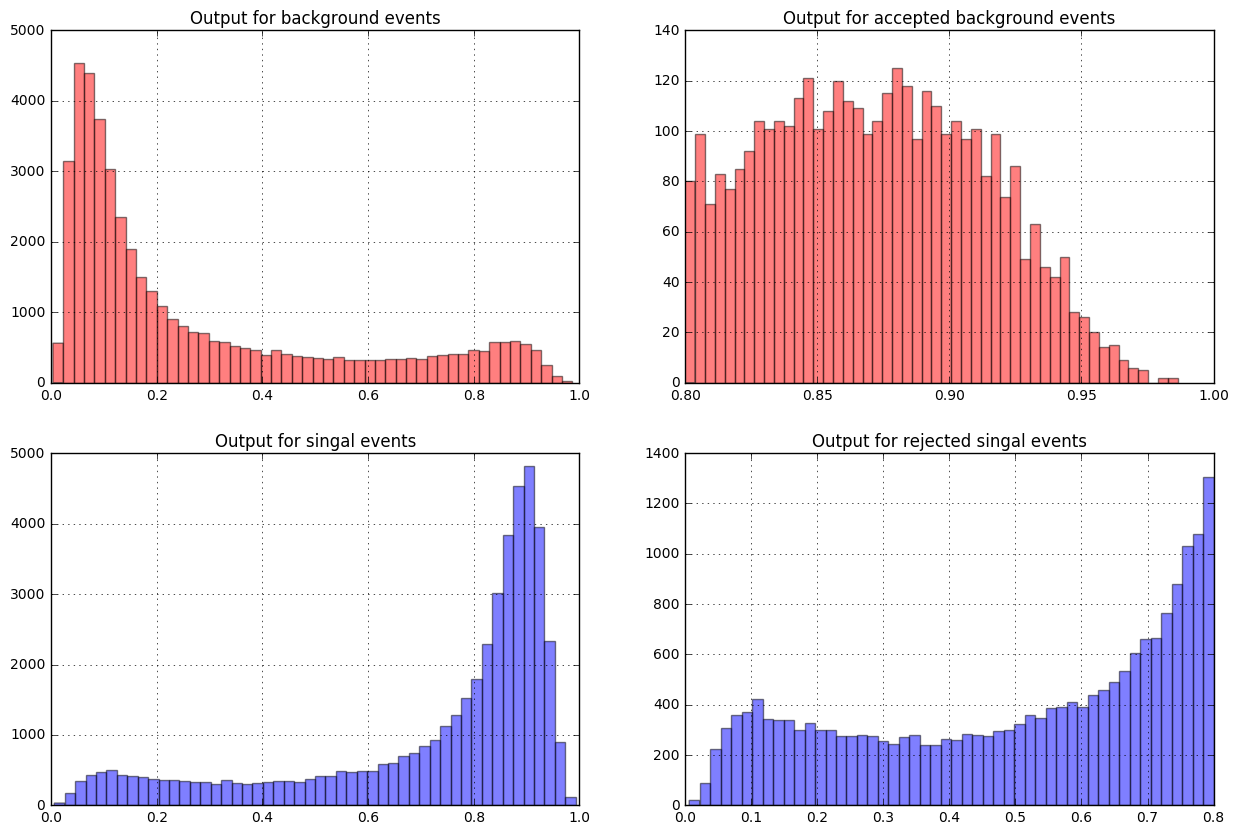

In [11]:
#T = 0.897818
T = .8
#T = .5
accepted_bg = np.where(bg_pred > T)[0]  ##  also use 
rej_si = np.where(si_pred < T)[0]       ##  these later
print('---Imposing ' + str(T) + ' threshold.---')
print('Accepted background events: ' + str(len(accepted_bg)))
print('Rejected signal events:     ' + str(len(rej_si)))
print('Efficiency:                 ' + str(1-float(len(rej_si))/float(len(si_pred))))
print('Background acceptance rate: ' + str(float(len(accepted_bg))/float(len(bg_pred))))
print('FOM:                        ' + str((1-float(len(rej_si))/float(len(si_pred)))/float(np.sqrt(len(accepted_bg)/float(len(bg_pred))))))
print('')

fig = plt.figure();
fig.set_figheight(10.0)
fig.set_figwidth(15.0)
fig.add_subplot(221)
plt.hist(bg_pred, 50, facecolor='red', alpha=0.5)
plt.grid(True)
plt.title('Output for background events')

fig.add_subplot(222)
plt.hist(bg_pred[accepted_bg], 50, facecolor='red', alpha=0.5)
plt.grid(True)
plt.title('Output for accepted background events')

fig.add_subplot(223)
plt.hist(si_pred, 50, facecolor='blue', alpha=0.5)
plt.grid(True)
plt.title('Output for singal events')

fig.add_subplot(224)
plt.hist(si_pred[rej_si], 50, facecolor='blue', alpha=0.5)
plt.grid(True)
plt.title('Output for rejected singal events')
plt.show()

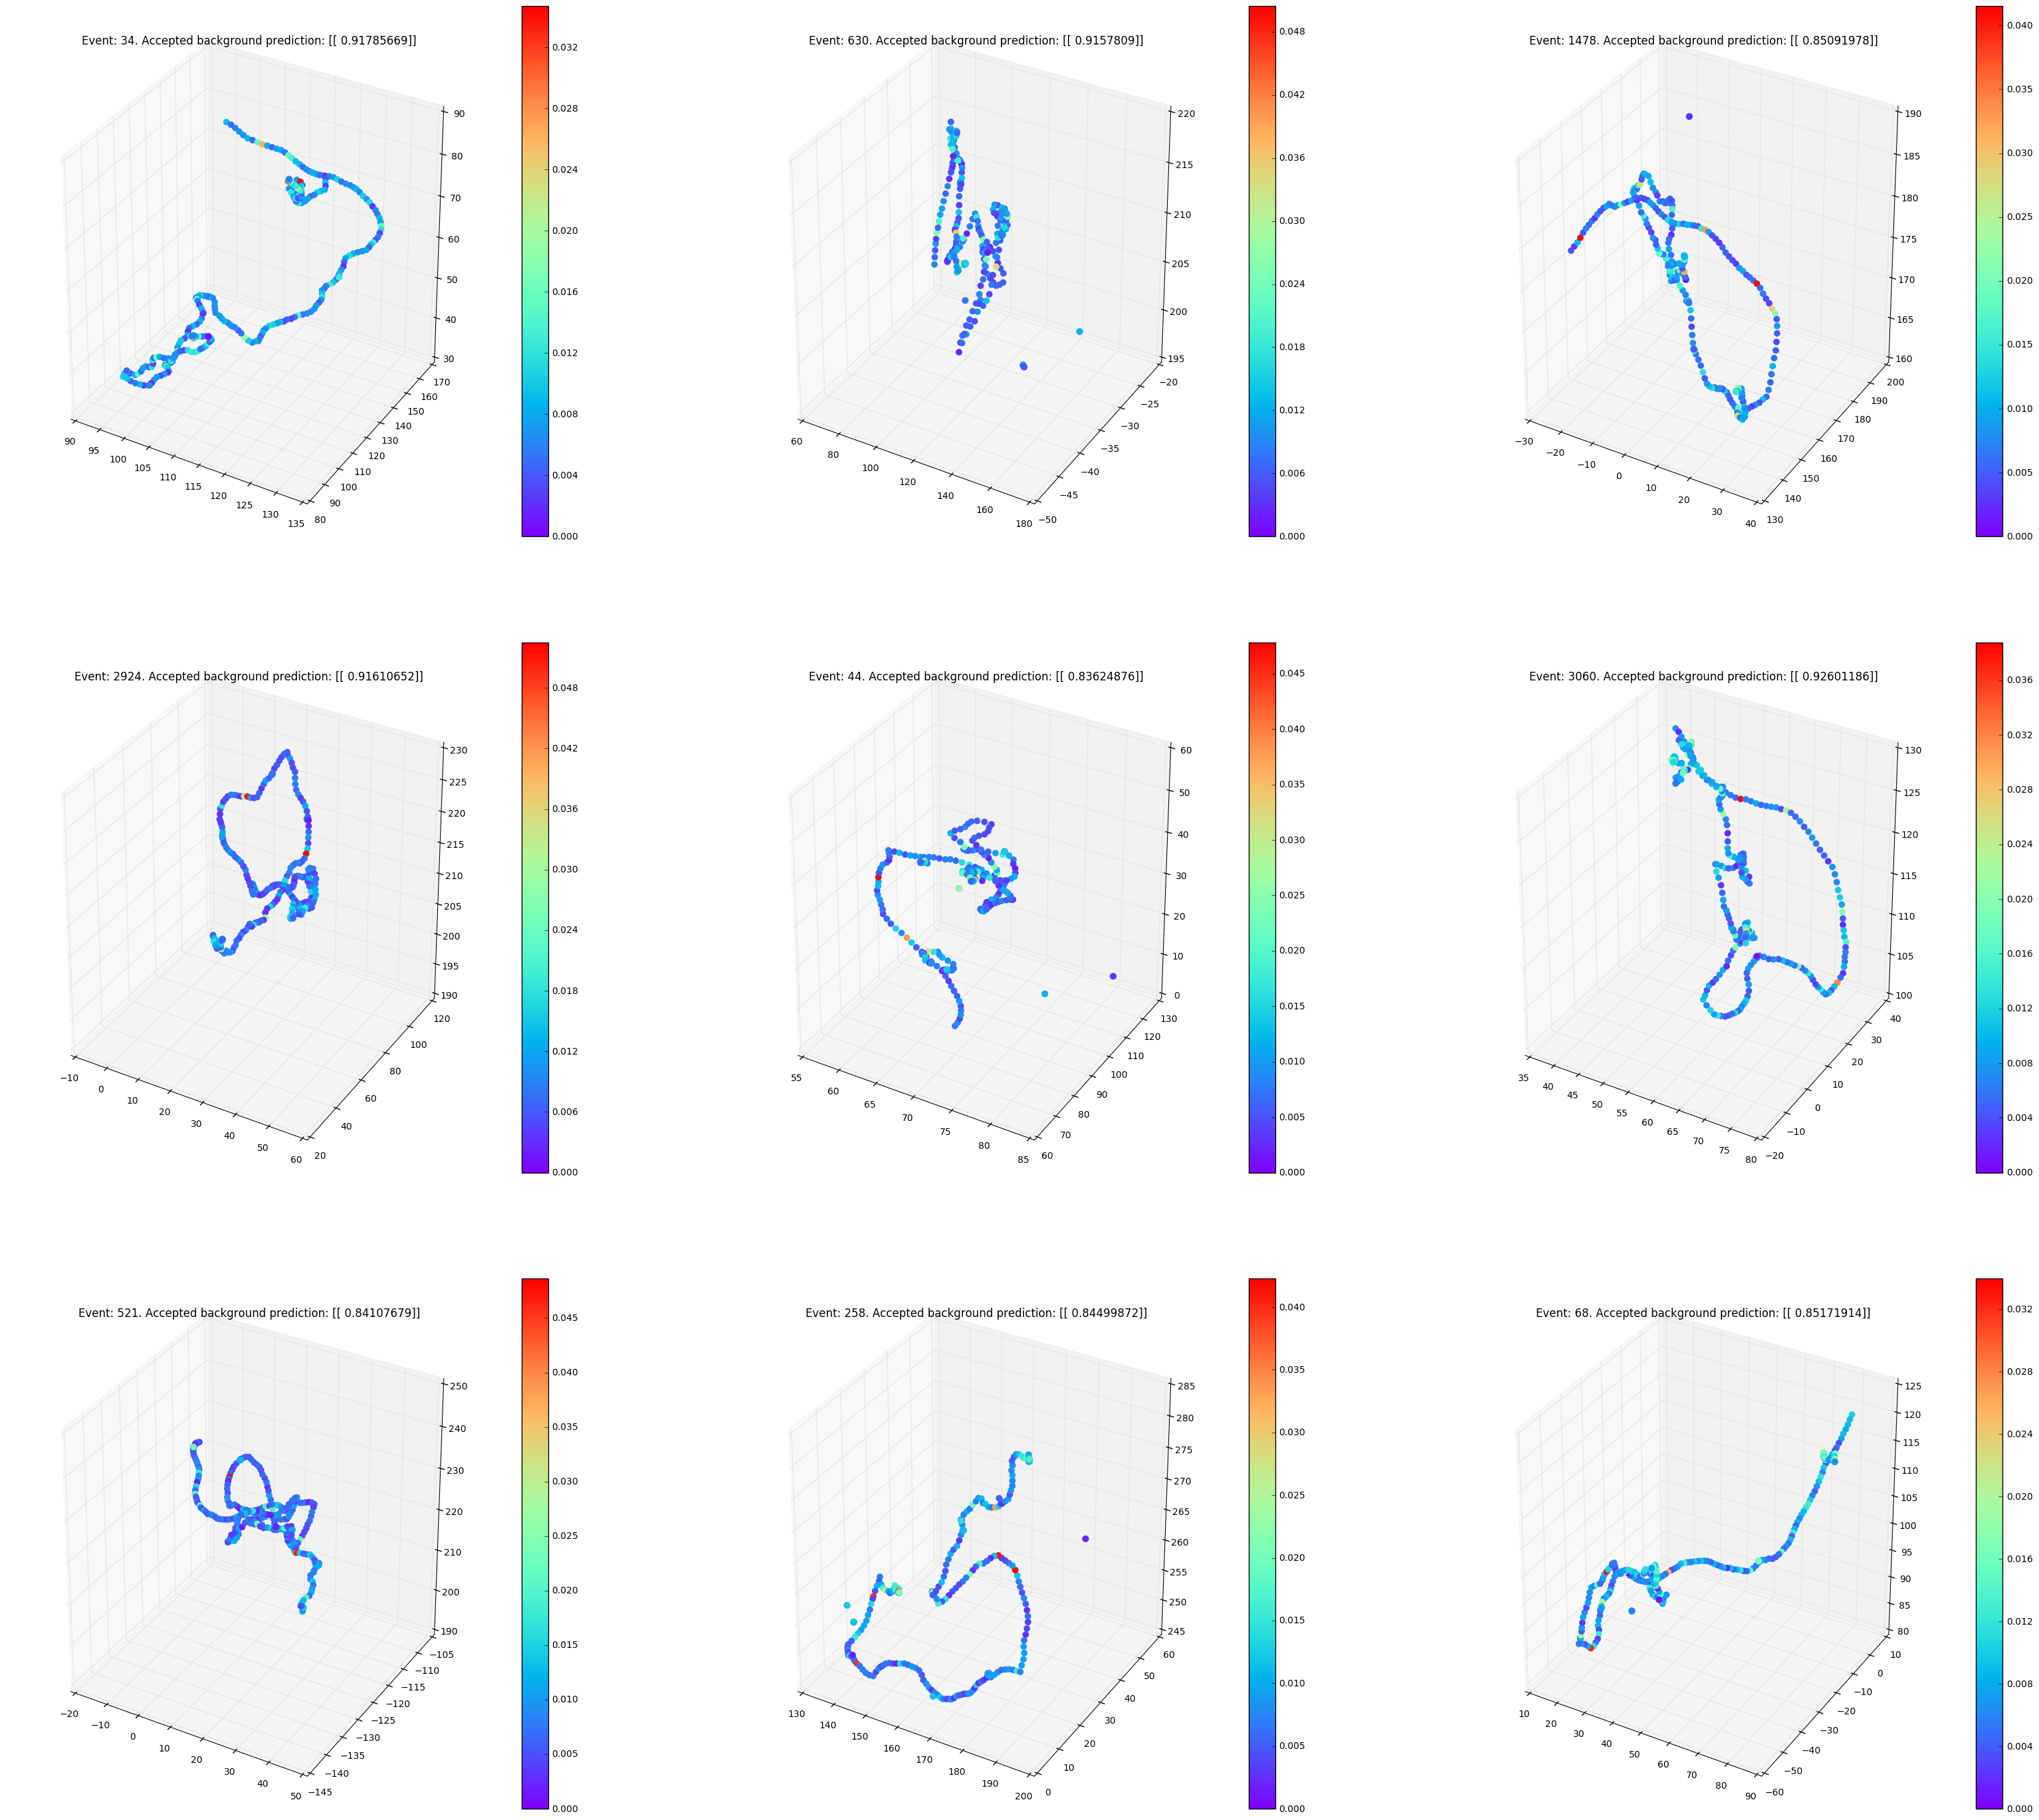

In [12]:
bg_path = '/home/jrenner/data/SE/se_1M_v0_08_07/'


accbg_evt = btest_evt[accepted_bg]
accbg_evt = np.reshape(accbg_evt, (len(accbg_evt),))

total_files = 25
high_energy = 0.4

total_ev = 0
total_gammas = 0
total_acc_gammas = 0
nevt_mht = 0
nacc_mht = 0
nrej_mht = 0
total_accbg_searched = 0
bg_e = np.array([]).reshape(0,2)
accbg_e = np.array([]).reshape(0,2)
rejbg_e = np.array([]).reshape(0,2)

for fn in range(total_files):
    filename = 'hdf5_NEXT_NEW_se_1M_v0_08_07_{0}.h5'.format(fn)
    f = tb.open_file(bg_path + filename, 'r')
    bg = f.root.MC.MCTracks

    # Get accepted bg in this file
    fmin = np.min(bg[:]['event_indx'])
    fmax = np.max(bg[:]['event_indx'])

    # Why does this not work in one line with 'and' or &
    f_accbg = accbg_evt[np.where(accbg_evt >= fmin)[0]]
    f_accbg = f_accbg[np.where(f_accbg <= fmax)[0]]
    total_accbg_searched += len(f_accbg)

    #print('Found ' + str(len(f_accbg)) + ' accepted background events in this file.')

    # Plot a few accepted background from the first file
    if fn == 0:
        plot_tracks(bg, f_accbg, bg_pred, btest_evt)
        
    # Count events with gammas
    f_acc_gammas, f_gammas, f_total_ev = count_gammas(bg, f_accbg)
    total_ev += f_total_ev
    total_gammas += f_gammas
    total_acc_gammas += f_acc_gammas
    
    # Count events with multiple high energy tracks
    f_nevt_mht, f_nacc_mht, f_nrej_mht = count_mht(bg, f_accbg, high_energy, f_total_ev)
    nevt_mht += f_nevt_mht
    nacc_mht += f_nacc_mht
    nrej_mht += f_nrej_mht
    
    # Collect 2 max tracks for all events
    f_bg_e, f_accbg_e, f_rejbg_e = get_max_track_energies(bg, f_accbg, f_total_ev) 
    bg_e = np.concatenate((bg_e, f_bg_e))
    accbg_e = np.concatenate((accbg_e, f_accbg_e))
    rejbg_e = np.concatenate((rejbg_e, f_rejbg_e))

In [13]:
print('Probability of gamma in accepted bg event: ' + str(float(total_acc_gammas)/total_accbg_searched))
print('Probability of gamma in bg event:          ' + str(float(total_gammas)/total_ev))
print('So the mere presence of a gamma does not seem to affect classification much')
print('')
print('---High Energy Threshold set to ' + str(float(high_energy)) + ' MeV')
print(str(round(float(nevt_mht)/total_ev*100)) + '% of total bg events have multiple high energy tracks') 
print(str(round(float(nacc_mht)/total_accbg_searched*100)) + '% of accepted bg events have multiple high energy tracks')
print(str(round(float(nrej_mht)/(total_ev - total_accbg_searched)*100)) + '% of rejected bg events have multiple high energy tracks') 
print('So the presence of multiple high energy tracks confuses the DNN.')

Probability of gamma in accepted bg event: 0.821664464993
Probability of gamma in bg event:          0.848770926256
So the mere presence of a gamma does not seem to affect classification much

---High Energy Threshold set to 0.4 MeV
13.0% of total bg events have multiple high energy tracks
49.0% of accepted bg events have multiple high energy tracks
10.0% of rejected bg events have multiple high energy tracks
So the presence of multiple high energy tracks confuses the DNN.


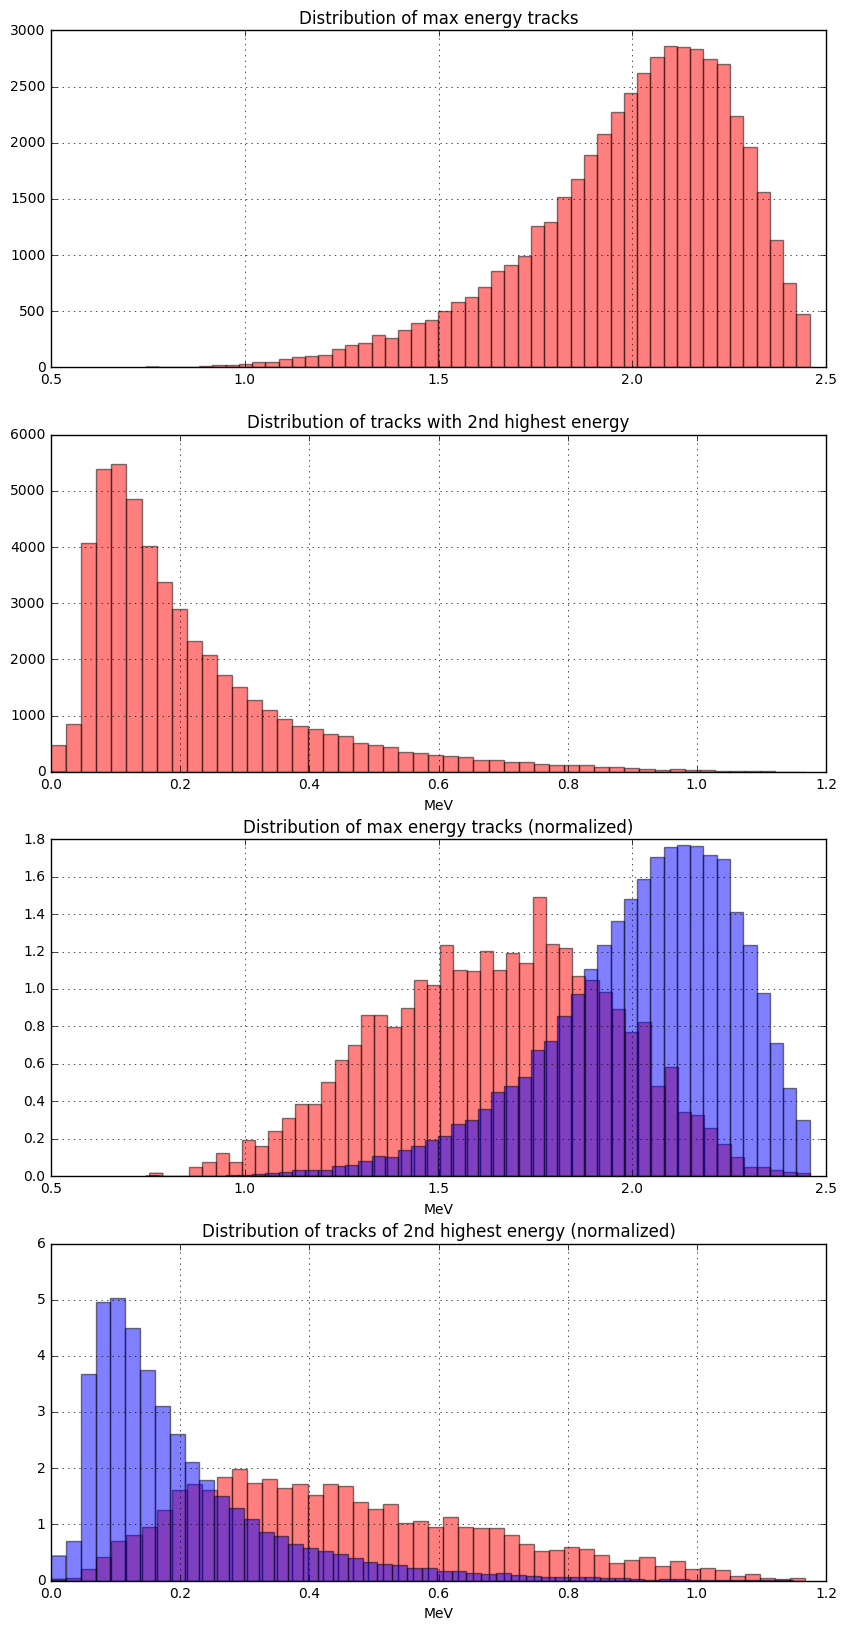

Blue = Rejected background
Red = Accepted background


In [14]:
fig = plt.figure();
fig.set_figheight(20.0)
fig.set_figwidth(10.0)

fig.add_subplot(411)
plt.hist(bg_e[:,0], 50, facecolor='red', alpha=0.5)
plt.grid(True)
plt.title('Distribution of max energy tracks')

fig.add_subplot(412)
plt.hist(bg_e[:,1], 50, facecolor='red', alpha=0.5)
plt.grid(True)
plt.title('Distribution of tracks with 2nd highest energy')
plt.xlabel('MeV')

fig.add_subplot(413)
plt.hist(accbg_e[:,0], 50, normed=1, facecolor='red', alpha=0.5, label='accepted bg')
plt.hist(rejbg_e[:,0], 50, normed=1, facecolor='blue', alpha=0.5, label='rejected bg')
plt.grid(True)
plt.title('Distribution of max energy tracks (normalized)')
plt.xlabel('MeV')

fig.add_subplot(414)
plt.hist(accbg_e[:,1], 50, normed=1, facecolor='red', alpha=0.5, label='accepted bg')
plt.hist(rejbg_e[:,1], 50, normed=1, facecolor='blue', alpha=0.5, label='rejected bg')
plt.grid(True)
plt.title('Distribution of tracks of 2nd highest energy (normalized)')
plt.xlabel('MeV')
plt.show()

print('Blue = Rejected background')
print('Red = Accepted background')

In [15]:
f.close()

Note the data in the above histograms are normalized, so that you can see the accepted background events. There are 5x more rejected background events so unnormalized, they are difficult to see. 